In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import cdist
from pyproj import Proj, transform
import oci_etl as etl

In [2]:
# Load the ACOLITE-processed L2R
file_path = 'C:/SwitchDrive/L3P/PACE_products/ACOLITE_Output/PACE_OCI_2024_08_28_12_00_53_L2R_projected.nc'
dataset = nc.Dataset(file_path)

### 1. Generate rho_s RGB

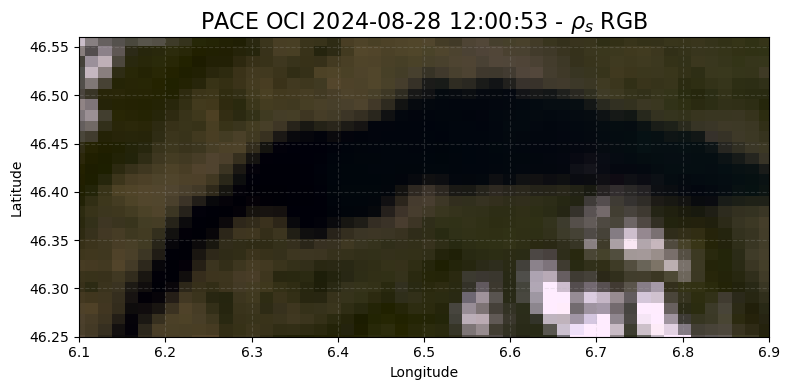

In [5]:
# get rhos bands from ACOLITE-OCI
rhos_bands = etl.extract_bands(dataset, 'rhos_', 351, 802)

#wavelengths for RGB
red = rhos_bands[640] 
green = rhos_bands[560]
blue = rhos_bands[442]

# generate RGB stack
rgb = np.dstack((red, green, blue))

# normalize and apply individual scaling to each channel
rgb_norm = np.zeros_like(rgb)
for i in range(3):
    channel = rgb[:,:,i]
    p2, p98 = np.percentile(channel, (2, 98))
    rgb_norm[:,:,i] = np.clip((channel - p2) / (p98 - p2), 0, 1)

# optional: Adjust color balance
rgb_balanced = rgb_norm.copy()
rgb_balanced[:,:,1] *= 0.9  # reduce green channel intensity

# apply gamma correction
gamma = 0.7
rgb_corrected = np.power(rgb_balanced, gamma)

# latitude and longitude
lat = dataset['lat'][:]
lon = dataset['lon'][:]

# Plot
fig, ax = plt.subplots(figsize=(8, 4))

# gamma-corrected RGB image
ax.imshow(rgb_corrected, extent=[lon.min(), lon.max(), lat.min(), lat.max()], aspect='auto')

ax.set_title(r'PACE OCI 2024-08-28 12:00:53 - $\rho_s$ RGB', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(6.1, 6.9)
ax.set_ylim(46.25, 46.56)
ax.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
#plt.savefig('C:/SwitchDrive/L3P/PACE_products/pace_rhos_rgb.png',dpi=400,bbox_inches='tight')

plt.show()

### 2. Generate rho_s(560) with location markers

c:\Anaconda3\envs\geo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Anaconda3\envs\geo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_34256\2495956760.py:32: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = 

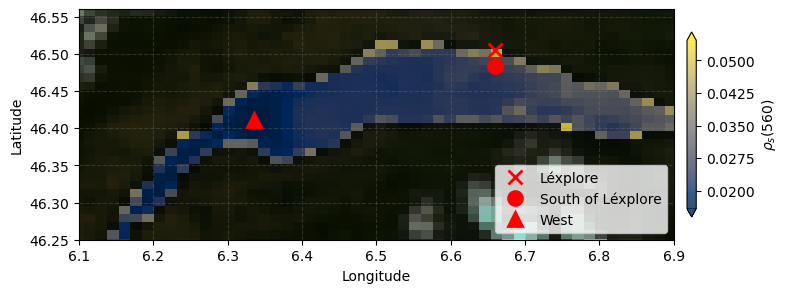

Number of pixels with rhos_red_800 < 0.05: 354
Total number of pixels: 2232
Percentage of pixels plotted with rhos_blue_560: 15.86%
Closest pixel to target coordinates: (10, 45)
Lat, Lon of closest pixel: (46.50481033325195, 6.65914249420166)
Lat, Lon of southern point: (46.48322677612305, 6.660068988800049)
Lat, Lon of new point: (46.41131591796875, 6.335249423980713)


In [6]:
# Extract bands for rhos
rhos_bands = etl.extract_bands(dataset, 'rhos_', 351, 802)

# Extract necessary bands
rhos_blue_560 = rhos_bands[560]
rhos_red_800 = rhos_bands[802]
red = rhos_bands[681]
green = rhos_bands[560]
blue = rhos_bands[440]

#stack
rgb = np.dstack((red, green, blue))
rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())

#mask
mask = rhos_red_800 < 0.1

# lat, lon
lat = dataset['lat'][:]
lon = dataset['lon'][:]

# find the closest pixel to the given coordinates (Lexplore here)
target_lat, target_lon = 46.50001, 6.660878
coords = np.column_stack((lat.ravel(), lon.ravel()))
target_coord = np.array([[target_lat, target_lon]])
distances = cdist(coords, target_coord)
closest_index = np.unravel_index(np.argmin(distances), lat.shape)

# calculate the point 2300 meters south (approx. 2 pixels)
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3857')
x, y = transform(inProj, outProj, target_lon, target_lat)
x_south, y_south = x, y - 2300
lon_south, lat_south = transform(outProj, inProj, x_south, y_south)

# find the closest pixel to the southern point
south_coord = np.array([[lat_south, lon_south]])
south_distances = cdist(coords, south_coord)
south_index = np.unravel_index(np.argmin(south_distances), lat.shape)

# new point coordinates - western Geneva
new_lat, new_lon = 46.411003, 6.333450

# find the closest pixel to the new point
new_coord = np.array([[new_lat, new_lon]])
new_distances = cdist(coords, new_coord)
new_index = np.unravel_index(np.argmin(new_distances), lat.shape)

# plot
fig, ax = plt.subplots(figsize=(8, 4))

# plot RGB where mask is False
ax.imshow(np.where(mask[..., np.newaxis], 0, rgb_norm), extent=[lon.min(), lon.max(), lat.min(), lat.max()])

# plot rhos_blue_560 where mask is True
masked_data = np.ma.masked_where(~mask, rhos_blue_560)
cmap = plt.cm.cividis
cmap.set_bad(alpha=0)  # masked values to transparent
im = ax.imshow(masked_data, cmap=cmap, alpha=0.8, extent=[lon.min(), lon.max(), lat.min(), lat.max()])

# cbar
cbar = plt.colorbar(im, shrink=0.5, fraction=0.08, pad=0.02,  extend='both')
cbar.set_label(r'$\rho_s(560)$')
cbar.set_ticks(np.linspace(0.02, 0.05, 5))

# red X at the closest pixel to the target coordinates
ax.plot(lon[closest_index], lat[closest_index], 'rx', markersize=10, markeredgewidth=2, label='Léxplore')
# red circle at the southern point
ax.plot(lon[south_index], lat[south_index], 'ro', markersize=10, markeredgewidth=2, label='South of Léxplore')
# red triangle at the new point west
ax.plot(lon[new_index], lat[new_index], 'r^', markersize=10, markeredgewidth=2, label='West')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, ls='--', alpha=0.3, c='grey')
ax.legend(loc='lower right')
ax.set_xlim(6.1, 6.9)
ax.set_ylim(46.25, 46.56)

plt.tight_layout()
#plt.savefig('C:/SwitchDrive/L3P/PACE_products/pace_rhos_560.png',dpi=400,bbox_inches='tight')
plt.show()

# Print some statistics
print(f"Number of pixels with rhos_red_800 < 0.05: {np.sum(mask)}")
print(f"Total number of pixels: {mask.size}")
print(f"Percentage of pixels plotted with rhos_blue_560: {np.sum(mask) / mask.size * 100:.2f}%")
print(f"Closest pixel to target coordinates: ({closest_index[0]}, {closest_index[1]})")
print(f"Lat, Lon of closest pixel: ({lat[closest_index]}, {lon[closest_index]})")
print(f"Lat, Lon of southern point: ({lat[south_index]}, {lon[south_index]})")
print(f"Lat, Lon of new point: ({lat[new_index]}, {lon[new_index]})")


## 3. Generate some IOP/Zsd products

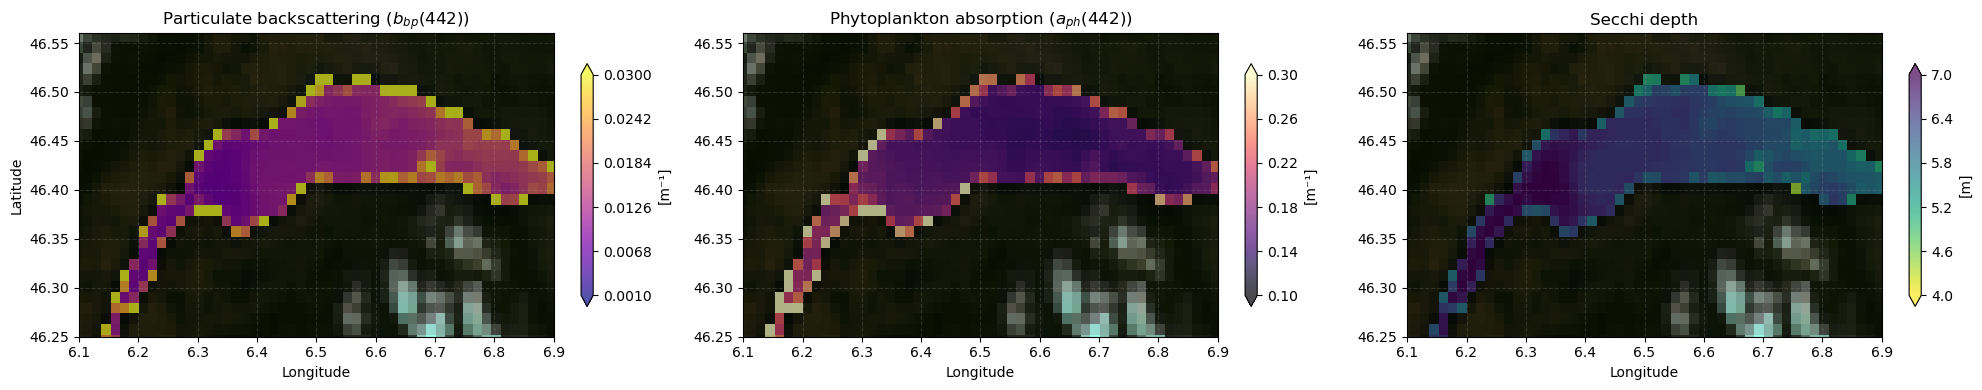


Particulate backscattering ($b_{bp}(442)$) Statistics:
Minimum: 0.01
Maximum: 0.05
Mean: 0.02
Median: 0.01
1st percentile: 0.01
99th percentile: 0.04
Number of valid pixels: 354
Number of zeros: 0
Number of NaNs: 1878

Phytoplankton absorption ($a_{ph}(442)$) Statistics:
Minimum: 0.14
Maximum: 0.40
Mean: 0.18
Median: 0.16
1st percentile: 0.14
99th percentile: 0.36
Number of valid pixels: 354
Number of zeros: 0
Number of NaNs: 1878


c:\Anaconda3\envs\geo_env\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Anaconda3\envs\geo_env\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [7]:
rhos_bands = etl.extract_bands(dataset, 'rhos_', 351, 802)

# create mask
rhos_red_800 = rhos_bands[802]
mask = rhos_red_800 < 0.1

# extract specific bands
rhos_442 = rhos_bands[442]
rhos_490 = rhos_bands[490]
rhos_560 = rhos_bands[560]
rhos_671 = rhos_bands[671]

# convert rhos to rrs
rrs_442 = rhos_442 / np.pi
rrs_490 = rhos_490 / np.pi
rrs_560 = rhos_560 / np.pi
rrs_671 = rhos_671 / np.pi

# QAA algorithm implementation
def qaa_v6(rrs_442, rrs_490, rrs_560, rrs_671):
    # Step 1: Calculate rrs
    rrs = {
        442: rrs_442 / (0.52 + 1.7 * rrs_442),
        490: rrs_490 / (0.52 + 1.7 * rrs_490),
        560: rrs_560 / (0.52 + 1.7 * rrs_560),
        671: rrs_671 / (0.52 + 1.7 * rrs_671)
    }
    
    # step 2: Calculate u
    g0, g1 = 0.089, 0.1245
    u = lambda wavelength: (-g0 + (g0**2 + 4*g1*rrs[wavelength])**0.5) / (2*g1)
    
    # step 3: Calculate a(560)
    a_560 = 0.0596 + 0.2*(rrs[671] / rrs[490]) * 0.39*(rrs[671] / rrs[490])**0.14
    
    # step 4: Calculate bbp(560)
    bbw_560 = 0.0007077  # Water backscattering at 560 nm
    bbp_560 = (u(560) * a_560) / (1 - u(560)) - bbw_560
    
    # step 5: Calculate η
    η = 2.0 * (1 - 1.2 * np.exp(-0.9 * rrs[442] / rrs[560]))
    
    # step 6: Calculate bbp for all wavelengths
    bbp = lambda wavelength: bbp_560 * (560 / wavelength)**η
    
    # step 7: Calculate a for all wavelengths
    a = lambda wavelength: (1 - u(wavelength)) * (bbw_560 + bbp(wavelength)) / u(wavelength)
    
    # step 8: Calculate adg(442)
    adg_442 = (a(442) - a(671)) / (np.exp(-0.015 * (442 - 671)) - 1)
    
    # step 9: Calculate aph
    aw = {442: 0.00635, 490: 0.015, 560: 0.0596, 671: 0.434}  
    aph = lambda wavelength: a(wavelength) - adg_442 * np.exp(-0.015 * (wavelength - 442)) - aw[wavelength]
    
    return a, bbp, aph

# apply QAA to valid pixels
valid_pixels = mask & (rrs_442 > 0) & (rrs_490 > 0) & (rrs_560 > 0) & (rrs_671 > 0)

bbp = np.full_like(rrs_442, np.nan, dtype=float)
aph = np.full_like(rrs_442, np.nan, dtype=float)

a, bbp_func, aph_func = qaa_v6(rrs_442[valid_pixels], rrs_490[valid_pixels], rrs_560[valid_pixels], rrs_671[valid_pixels])

bbp[valid_pixels] = bbp_func(442)
aph[valid_pixels] = aph_func(442)

# Some empirical Zsd calculation
def calculate_secchi_depth(rrs_490):
    kd490 = 0.0166 + 1.2815 * rrs_490
    secchi_depth = 0.15 / kd490
    return secchi_depth

secchi_depth = np.full_like(rrs_490, np.nan, dtype=float)
secchi_depth[valid_pixels] = calculate_secchi_depth(rrs_490[valid_pixels])

# RGB
red = rhos_bands[681]
green = rhos_bands[560]
blue = rhos_bands[440]
rgb = np.dstack((red, green, blue))
rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())

# lat, lon
latitude = dataset.variables['lat'][:]
longitude = dataset.variables['lon'][:]

# plotting
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
products = [bbp, aph, secchi_depth]
titles = [r'Particulate backscattering ($b_{bp}(442)$)', r'Phytoplankton absorption ($a_{ph}(442)$)', 'Secchi depth']
cmaps = ['plasma', 'magma', 'viridis_r']
units = ['[m⁻¹]', '[m⁻¹]', '[m]']
vmin_vmax = [(0.001, 0.03), (0.1, 0.3), (4, 7)]

lon_min, lon_max = 6.1, 6.9
lat_min, lat_max = 46.25, 46.56

for i, (ax, product, title, cmap, unit, (vmin, vmax)) in enumerate(zip(axs.ravel(), products, titles, cmaps, units, vmin_vmax)):
    # RGB image as background
    ax.imshow(rgb_norm, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()], aspect='auto')
    
    # mask for invalid data
    mask = np.isnan(product)
    
    # product data
    im = ax.imshow(np.ma.masked_where(mask, product), 
                   cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.7,
                   extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                   aspect='auto')
    
    cbar = plt.colorbar(im, ax=ax, label=unit, shrink=0.8, fraction=0.08, extend='both')
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    if i == 0:  # only set y-label for the first plot
        ax.set_ylabel('Latitude')
    else:
        ax.set_ylabel('')  # remove y-label for other plots
    
    ax.grid(True, linestyle='--', alpha=0.2)
    
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)

plt.tight_layout()
#plt.savefig('C:/SwitchDrive/L3P/PACE_products/pace_l2w_products.png',dpi=400,bbox_inches='tight')
plt.show()


# some stats
for product, title in zip(products[:-1], titles[:-1]):  # exclude RGB image from statistics
    valid_data = product[np.isfinite(product)]
    print(f"\n{title} Statistics:")
    print(f"Minimum: {np.min(valid_data):.2f}")
    print(f"Maximum: {np.max(valid_data):.2f}")
    print(f"Mean: {np.mean(valid_data):.2f}")
    print(f"Median: {np.median(valid_data):.2f}")
    print(f"1st percentile: {np.percentile(valid_data, 1):.2f}")
    print(f"99th percentile: {np.percentile(valid_data, 99):.2f}")
    print(f"Number of valid pixels: {len(valid_data)}")
    print(f"Number of zeros: {np.sum(valid_data == 0)}")
    print(f"Number of NaNs: {np.sum(np.isnan(product))}")

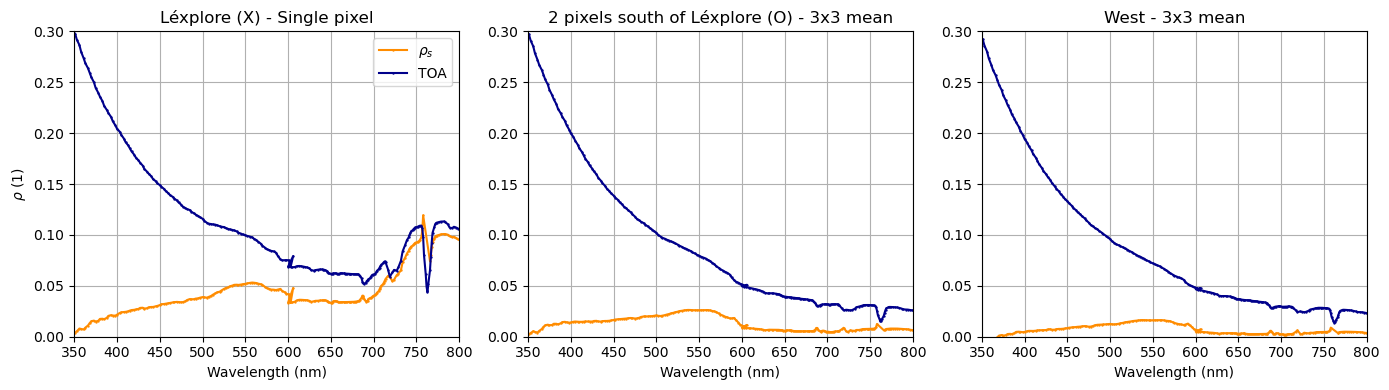

In [3]:
# Extract bands for rhos and rhot
rhos_bands = etl.extract_bands(dataset, 'rhos_', 351, 800)
rhot_bands = etl.extract_bands(dataset, 'rhot_', 351, 800)

lat = dataset['lat'][:]
lon = dataset['lon'][:]

# Find pixel indices for all three locations
index_1 = etl.find_closest_pixel(46.50001, 6.660878, lat, lon)  # Lexplore
index_2 = (index_1[0] + 2, index_1[1])  # 2 pixels south of Lexplore
index_3 = etl.find_closest_pixel(46.411003, 6.333450, lat, lon)  # New location west

# Extract spectral data for all three locations
rhos_spectrum_1 = etl.extract_spectral_data(rhos_bands, index_1, use_average=False)
rhot_spectrum_1 = etl.extract_spectral_data(rhot_bands, index_1, use_average=False)

rhos_spectrum_2 = etl.extract_spectral_data(rhos_bands, index_2, use_average=True)
rhot_spectrum_2 = etl.extract_spectral_data(rhot_bands, index_2, use_average=True)

rhos_spectrum_3 = etl.extract_spectral_data(rhos_bands, index_3, use_average=True)
rhot_spectrum_3 = etl.extract_spectral_data(rhot_bands, index_3, use_average=True)

# Create the subplot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

# Plot for the original point (Lexplore)
ax1.plot(list(rhos_spectrum_1.keys()), list(rhos_spectrum_1.values()), color='darkorange', marker='o', label=r'$\rho_s$', markersize=0.7)
ax1.plot(list(rhot_spectrum_1.keys()), list(rhot_spectrum_1.values()), color='darkblue', marker='o', label='TOA', markersize=0.7)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel(r'$\rho \ (1)$')
ax1.set_xlim(350, 800)
ax1.set_ylim(0, 0.3)
ax1.set_title('Léxplore (X) - Single pixel')
ax1.legend()
ax1.grid(True)

# Plot for the southern point
ax2.plot(list(rhos_spectrum_2.keys()), list(rhos_spectrum_2.values()), color='darkorange', marker='o', label=r'$\rho_s$', markersize=0.7)
ax2.plot(list(rhot_spectrum_2.keys()), list(rhot_spectrum_2.values()), color='darkblue', marker='o', label='TOA', markersize=0.7)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_xlim(350, 800)
ax2.set_ylim(0, 0.3)
ax2.set_title('2 pixels south of Léxplore (O) - 3x3 mean')
#ax2.legend()
ax2.grid(True)

# Plot for the new location
ax3.plot(list(rhos_spectrum_3.keys()), list(rhos_spectrum_3.values()), color='darkorange', marker='o', label=r'$\rho_s$', markersize=0.7)
ax3.plot(list(rhot_spectrum_3.keys()), list(rhot_spectrum_3.values()), color='darkblue', marker='o', label='TOA', markersize=0.7)
ax3.set_xlabel('Wavelength (nm)')
ax3.set_xlim(350, 800)
ax3.set_ylim(0, 0.3)
ax3.set_title('West - 3x3 mean')
#ax3.legend()
ax3.grid(True)

plt.tight_layout()
#plt.savefig('C:/SwitchDrive/L3P/PACE_products/pace_ps_spectra.png',dpi=400,bbox_inches='tight')
plt.show()